## Part 2 - Clustering

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for Part 2 of the coursework

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [3]:
x_train, y_train = load_train_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

### 1) K-means Clustering

We plotted the clusters for our train dataset by using a dimentionality reduction technique called PCA.

In [6]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=1) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

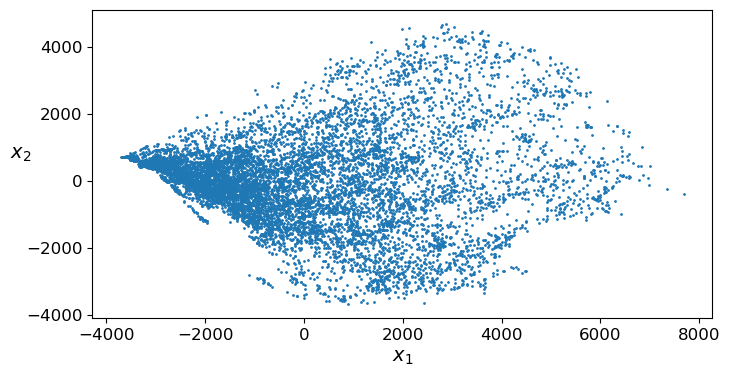

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(x_train, y_train)

plt.figure(figsize=(8, 4))
plot_clusters(X_pca1)
plt.show()

We then preprocessed the train dataset and plotted the clusters again.

In [8]:
# Created a list to store the labels that have less number of pictures
less_class_labels = [0, 5, 6, 7, 8, 9]

data_list = []
for index, row in x_train.iterrows():
    label = y_train.iloc[index, 0]
    image_data = row.values.reshape(48, 48)

    if label in less_class_labels:
        data_list.append((image_data, label))

subset_dataset = np.array(data_list, dtype=object)

print(subset_dataset.shape)

num_images_per_label = {label: np.sum(subset_dataset[:, 1] == label) for label in less_class_labels}

for label, num_images in num_images_per_label.items():
    print(f"Label {label}: {num_images} images")

(1830, 2)
Label 0: 210 images
Label 5: 210 images
Label 6: 360 images
Label 7: 240 images
Label 8: 540 images
Label 9: 270 images


In [9]:
def add_noise(feature_vector, noise_level=0.01):
    noise = np.random.normal(0, noise_level, feature_vector.shape)
    noisy_vector = feature_vector + noise
    return noisy_vector

In [10]:
def introduce_perturbations(feature_vector, perturbation_level=0.02):
    min_value = np.min(feature_vector)
    max_value = np.max(feature_vector)
    perturbations = np.random.uniform(-perturbation_level, perturbation_level, feature_vector.shape)
    perturbed_vector = feature_vector + perturbations * (max_value - min_value)
    return perturbed_vector

In [11]:
from scipy.stats.mstats import winsorize
x_train = np.array(x_train)

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=1.7, beta = 90)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(9690, 2304)

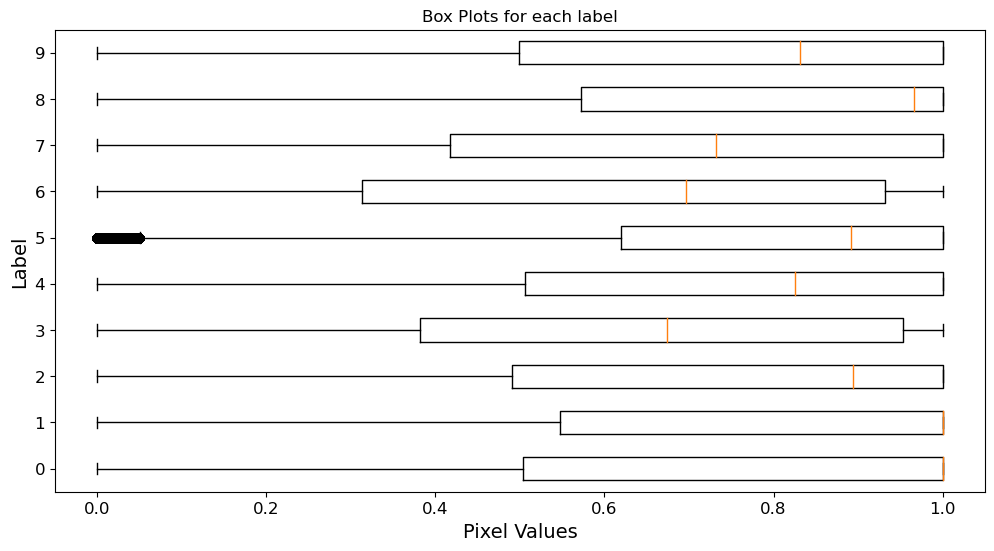

Label 0: 210 images
Label 1: 2220 images
Label 2: 2250 images
Label 3: 1410 images
Label 4: 1980 images
Label 5: 210 images
Label 6: 360 images
Label 7: 240 images
Label 8: 540 images
Label 9: 270 images


In [12]:
label_images = {}

num_images_per_label = {}

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

for index, row in x_train.iterrows():
    label = y_train.iloc[index, 0]  
    image_data = row.values.reshape(-1, 48, 48) 

    if label not in label_images:
        label_images[label] = []
    
    label_images[label].append(image_data)

    num_images_per_label[label] = len(label_images[label])

box_data = np.array(list(label_images.values()), dtype=object)

labels = list(label_images.keys())

plt.figure(figsize=(12, 6))
plt.boxplot(box_data, labels=labels, vert=False)
plt.title("Box Plots for each label")
plt.xlabel("Pixel Values")
plt.ylabel("Label")
plt.show()

for label, num_images in num_images_per_label.items():
    print(f"Label {label}: {num_images} images")

In [ ]:
#NO
print(x_train.shape)
print(y_train.shape)

augmented_data = []
new_augmented_data = []
labels_for_train = []
for data, label in subset_dataset:
    noisy_vector = add_noise(data, noise_level=0.01)  
    perturbed_vector = introduce_perturbations(data, perturbation_level=0.02)  
    
        # Append the original and augmented data with their respective labels
    augmented_data.append((data, label))
    augmented_data.append((noisy_vector, label))
    augmented_data.append((perturbed_vector, label))

# Convert the appended data to a NumPy array
for image_vectors, label_col in augmented_data:
    new_augmented_data.append(image_vectors)
    labels_for_train.append(label_col)

new_augmented_data = np.array(new_augmented_data)
labels_for_train = np.array(labels_for_train)

new_labels = labels_for_train.reshape(-1, 1)

new_augmented_data = new_augmented_data.reshape(new_augmented_data.shape[0], -1)

print(new_augmented_data.shape)
print(new_labels.shape)
if new_augmented_data.shape[1] == x_train.shape[1]:
    x_train = np.vstack((x_train, new_augmented_data))
    y_train = np.concatenate((y_train, new_labels))
else:
    print("Number of columns in appended_data doesn't match x_train.")

print(x_train.shape)
print(y_train.shape)

In [ ]:
#NO
rotation_angle = 15
scale_factor = 1.2

rotated_images = []

for image in x_train:
    image = image.reshape(48, 48)  
    rotated_image = cv2.warpAffine(image, cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), rotation_angle, scale_factor), (image.shape[1], image.shape[0]))
    rotated_images.append(rotated_image)

x_train = np.asarray(rotated_images)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

In [ ]:
#NO
from sklearn.preprocessing import StandardScaler
import cv2
import numpy as np

# Additional Pre processing
def preprocess_data(data):
    preprocessed_images = []
    
    for image in data:
        # Reshaping the image to its original shape
        image = image.reshape(48, 48)
        
        # Apply Gaussian blur to reduce noise
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
        
        # Apply sharpening filter to enhance image details
        sharpened_image = cv2.filter2D(blurred_image, -1, np.array([[-1, -1, -1],
                                                                    [-1,  9, -1],
                                                                    [-1, -1, -1]]))
        
        # Standardize pixel values using StandardScaler
        scaler = StandardScaler()
        standardized_image = scaler.fit_transform(sharpened_image)
        
        # Append the preprocessed image to the list
        preprocessed_images.append(standardized_image)
    
    preprocessed_data = np.asarray(preprocessed_images)
    
    # Reshape the data back to the flattened format
    preprocessed_data = preprocessed_data.reshape(preprocessed_data.shape[0], -1)
    
    return preprocessed_data

x_train = preprocess_data(x_train)
print(x_train.shape)

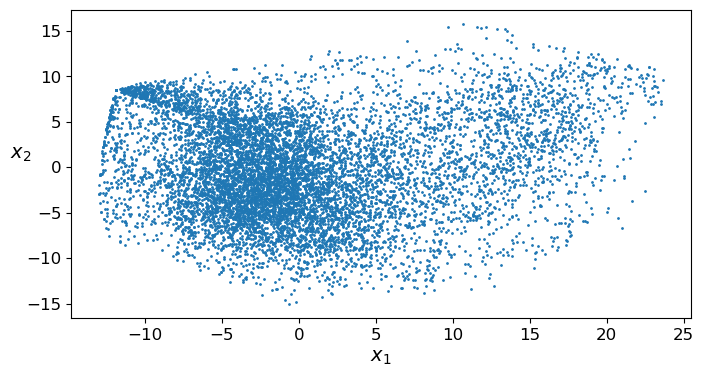

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(x_train, y_train)

plt.figure(figsize=(8, 4))
plot_clusters(X_pca2)
plt.show()

We train a K-Means clusterer on the dataset.

In [14]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(x_train)

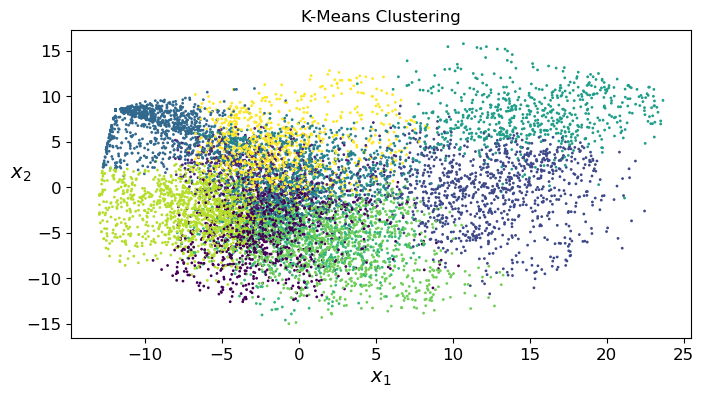

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(x_train)

plt.figure(figsize=(8, 4))
plt.title("K-Means Clustering")
plot_clusters(X_pca, cluster_labels)
plt.show()

In [16]:
cluster_labels

array([3, 3, 3, ..., 1, 2, 2], dtype=int32)

In [17]:
cluster_labels is kmeans.labels_

True

In [18]:
kmeans.cluster_centers_

array([[0.2928082 , 0.2928082 , 0.2928082 , ..., 0.81693919, 0.81693919,
        0.81693919],
       [0.82677476, 0.82677476, 0.82677476, ..., 0.78714462, 0.78714462,
        0.78714462],
       [0.73547387, 0.73547387, 0.73547387, ..., 0.3578545 , 0.3578545 ,
        0.3578545 ],
       ...,
       [0.3657948 , 0.3657948 , 0.3657948 , ..., 0.32884998, 0.32884998,
        0.32884998],
       [0.34914868, 0.34914868, 0.34914868, ..., 0.76543247, 0.76543247,
        0.76543247],
       [0.83216275, 0.83216275, 0.83216275, ..., 0.80608387, 0.80608387,
        0.80608387]])

In [19]:
kmeans.labels_

array([3, 3, 3, ..., 1, 2, 2], dtype=int32)

In [20]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(x_train, cluster_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.11685469693727153


In [21]:
from sklearn.preprocessing import StandardScaler

Silhouette Score with t-SNE + K-Means =  0.3667693


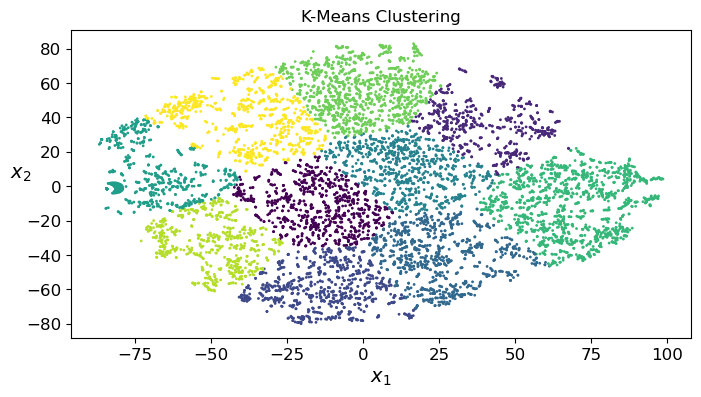

In [22]:
# 1. Reapply Standard Scaling and PCA
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# pca = PCA(n_components=0.85)  # Adjusting the variance to 85%
# x_train_pca = pca.fit_transform(x_train_scaled)

# # 2. t-SNE Dimensionality Reduction
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)

# Now apply K-means clustering on the t-SNE processed data
kmeans_tsne = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels_tsne = kmeans_tsne.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, cluster_labels_tsne)
print("Silhouette Score with t-SNE + K-Means = ", silhouette_scores_tsne)

from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(x_train)

plt.figure(figsize=(8, 4))
plt.title("K-Means Clustering")
plot_clusters(x_train_tsne, cluster_labels_tsne)
plt.show()

